# <b>RQ1: Are the results of the study of Dautriche et al. reproducible for English?</b>

In [96]:
import os
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from config import Globals

In [6]:
os.chdir("c:/Users/Raya/OneDrive/Documents/3-CSAI/CSAI-Y3-S2/Thesis/Replication")

In [97]:
globals = Globals()

<u>Pre-requisites</u>:
- Correlation scores between cosine distance and edit distance for word length 3-7.
- Baseline correlation scores from 10,000 random embedding-word reassignments for each word length.

# Correlation scores

In [20]:
# Get real-lexicon correlation scores
real_corr_scores_dir = os.path.join("results", "correlations", "real_corr_scores")

# Define significance levels based on p-value thresholds
def assign_significance_level(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return '-'

# Get a list of all files in the directory
files = [os.path.join(real_corr_scores_dir, f) for f in os.listdir(real_corr_scores_dir) if f.endswith('.csv')]

# Loop through each file in the directory
for file in files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Apply the function to each row's p-value to assign significance levels
    df['sig_level'] = df['p-value'].apply(assign_significance_level)
    
    # Display the DataFrame
    print(f"File: {file}")
    display(df)

File: results\correlations\real_corr_scores\real_corrs_abs.csv


,word_length,raw_corr,transformed_corr,p-value,sig_level
0,3,0.065035,0.065127,3.568279e-32,***
1,4,0.009350,0.009350,1.143745e-04,***
2,5,0.024521,0.024526,4.905868e-38,***
3,6,0.024084,0.024089,4.626933e-46,***
4,7,0.035843,0.035858,6.664459e-89,***


File: results\correlations\real_corr_scores\real_corrs_ang.csv


,word_length,raw_corr,transformed_corr,p-value,sig_level
0,3,0.065383,0.065477,1.674647e-32,***
1,4,0.013039,0.013040,7.444329e-08,***
2,5,0.025506,0.025511,5.185327e-41,***
3,6,0.023081,0.023085,1.903327e-42,***
4,7,0.033274,0.033286,7.173395e-77,***


File: results\correlations\real_corr_scores\real_corrs_none.csv


,word_length,raw_corr,transformed_corr,p-value,sig_level
0,3,0.067066,0.067166,4.115647e-34,***
1,4,0.012952,0.012952,9.093472e-08,***
2,5,0.024836,0.024841,5.655881e-39,***
3,6,0.023000,0.023004,3.695127e-42,***
4,7,0.032903,0.032915,3.293938e-75,***


File: results\correlations\real_corr_scores\real_corrs_norm.csv


,word_length,raw_corr,transformed_corr,p-value,sig_level
0,3,0.067066,0.067166,4.115647e-34,***
1,4,0.012952,0.012952,9.093472e-08,***
2,5,0.024836,0.024841,5.655881e-39,***
3,6,0.023000,0.023004,3.695127e-42,***
4,7,0.032903,0.032915,3.293938e-75,***


# Comparison with random baseline

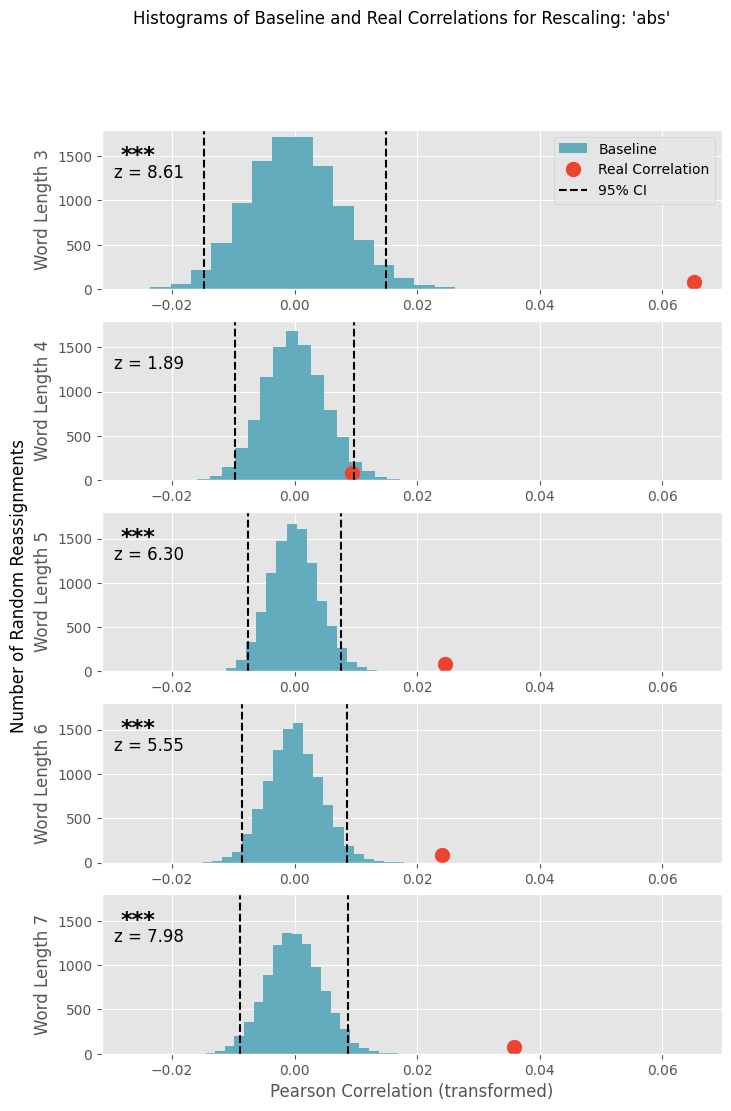

In [74]:
# Plot histogram of baseline correlations and the real correlation score

# Define the function
def plot_baseline_histograms(random_baseline_files, real_scores_files, transformed_corr=False, save_fig=False):
    """
    Plot histograms of baseline (random) and real correlations for rescaling 'abs'.

    Parameters:
        random_baseline_files (dict): A dictionary with rescaling types as keys and file paths to random baseline correlation files as values.
        real_scores_files (dict): A dictionary with rescaling types as keys and file paths to real-lexicon correlation files as values.
        transformed_corr (bool): If True, use transformed correlations; otherwise, use raw correlations.
        save_fig (bool): If True, save the figure; otherwise, display the plot.
    """
    # Define word lengths and focus on rescaling type 'abs' and baseline type 'random'
    word_lengths = [3, 4, 5, 6, 7]
    rescaling_type = 'abs'
    
    # Create a figure for the grid of subplots
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nrows=len(word_lengths), ncols=1, figsize=(8, 12), sharex=True, sharey=True)
    fig.suptitle(f"Pearson correlations between edit and cosine distance with rescaling: '{rescaling_type}'")

    # Load real lexicon correlation data
    real_file_path = real_scores_files[rescaling_type]
    df_real = pd.read_csv(real_file_path)
    
    # Select the appropriate correlation column based on transformed_corr
    correlation_column = 'transformed_corr' if transformed_corr else 'raw_corr'
    
    # Iterate through each word length (rows)
    for i, word_length in enumerate(word_lengths):
        # Filter real lexicon correlations by word length
        df_real_filtered = df_real[df_real['word_length'] == word_length]
        real_corr = df_real_filtered[correlation_column].iloc[0]
        
        # Select the appropriate file path for the current rescaling type and baseline type
        file_path = random_baseline_files[rescaling_type]

        # Load baseline data
        df_baseline = pd.read_csv(file_path)

        # Filter baseline data by word length
        df_baseline_filtered = df_baseline[df_baseline['word_length'] == word_length]

        # Plot histogram of baseline correlations
        ax = axes[i]
        ax.hist(df_baseline_filtered[correlation_column], color='#63acbe', bins=20, label='Baseline')

        # Plot real correlation as a dot
        ax.plot(real_corr, 80, "o", color="#ee442f", label='Real Correlation', markersize=10)

        # Calculate mean and standard deviation of baseline correlations
        mean_corr = df_baseline_filtered[correlation_column].mean()
        std_corr = df_baseline_filtered[correlation_column].std()

        # Calculate the 95% confidence interval
        ci_lower = mean_corr - 1.96 * std_corr
        ci_upper = mean_corr + 1.96 * std_corr

        # Plot vertical dotted lines for the 95% confidence interval
        ax.axvline(ci_lower, color='black', linestyle='dashed', label='95% CI')
        ax.axvline(ci_upper, color='black', linestyle='dashed')

        # Calculate z-score and p-value for real correlation
        z_score = (real_corr - mean_corr) / std_corr if std_corr != 0 else np.nan
        # p_value = np.exp(-0.5 * z_score**2) / np.sqrt(2 * np.pi) if z_score == z_score else np.nan
        p_value = scipy.stats.norm.sf(abs(z_score)) * 2 if z_score == z_score else np.nan # Two-tailed
        
        # Add z-score as text
        ax.text(0.02, 0.7, f'z = {z_score:.2f}', fontsize=12, transform=ax.transAxes)
        
        # Add significance markers based on the p-value
        if p_value < 0.05:
            significance_level = '*' if p_value >= 0.01 else '**' if p_value >= 0.001 else '***'
            ax.text(0.03, 0.8, significance_level, color='black', fontsize=16, fontweight='bold', transform=ax.transAxes)

        # Add row title
        ax.set_ylabel(f'Word Length {word_length}')
        if i == 0:
            ax.legend()
        if i == len(word_lengths) - 1:
            specs = 'transformed' if transformed_corr else 'raw'
            ax.set_xlabel(f'Pearson Correlation ({specs})')
        # Ensure x-tick labels are visible on each subplot
        ax.tick_params(axis='x', labelbottom=True)

    # Add common title and labels
    fig.suptitle(f"Histograms of Baseline and Real Correlations for Rescaling: '{rescaling_type}'")
    fig.text(0.01, 0.5, 'Number of Random Reassignments', va='center', rotation='vertical', fontsize=12)
    
    # Save or show the figure
    if save_fig:
        filename = f"histograms_{rescaling_type}.png"
        plt.savefig(os.path.join("plots", filename))
    else:
        plt.show()

# Define file paths for 'abs' rescaling and 'random' baseline type
rescaling_types = ['abs']
random_baseline_files = {rescaling: f'results/correlations/rd_baseline/rd_bl_corrs_{rescaling}.csv' for rescaling in rescaling_types}
real_scores_files = {rescaling: f'results/correlations/real_corr_scores/real_corrs_{rescaling}.csv' for rescaling in rescaling_types}

# Call the function for 'abs' rescaling and 'random' baseline type
plot_baseline_histograms(random_baseline_files, real_scores_files, transformed_corr=True, save_fig=False)

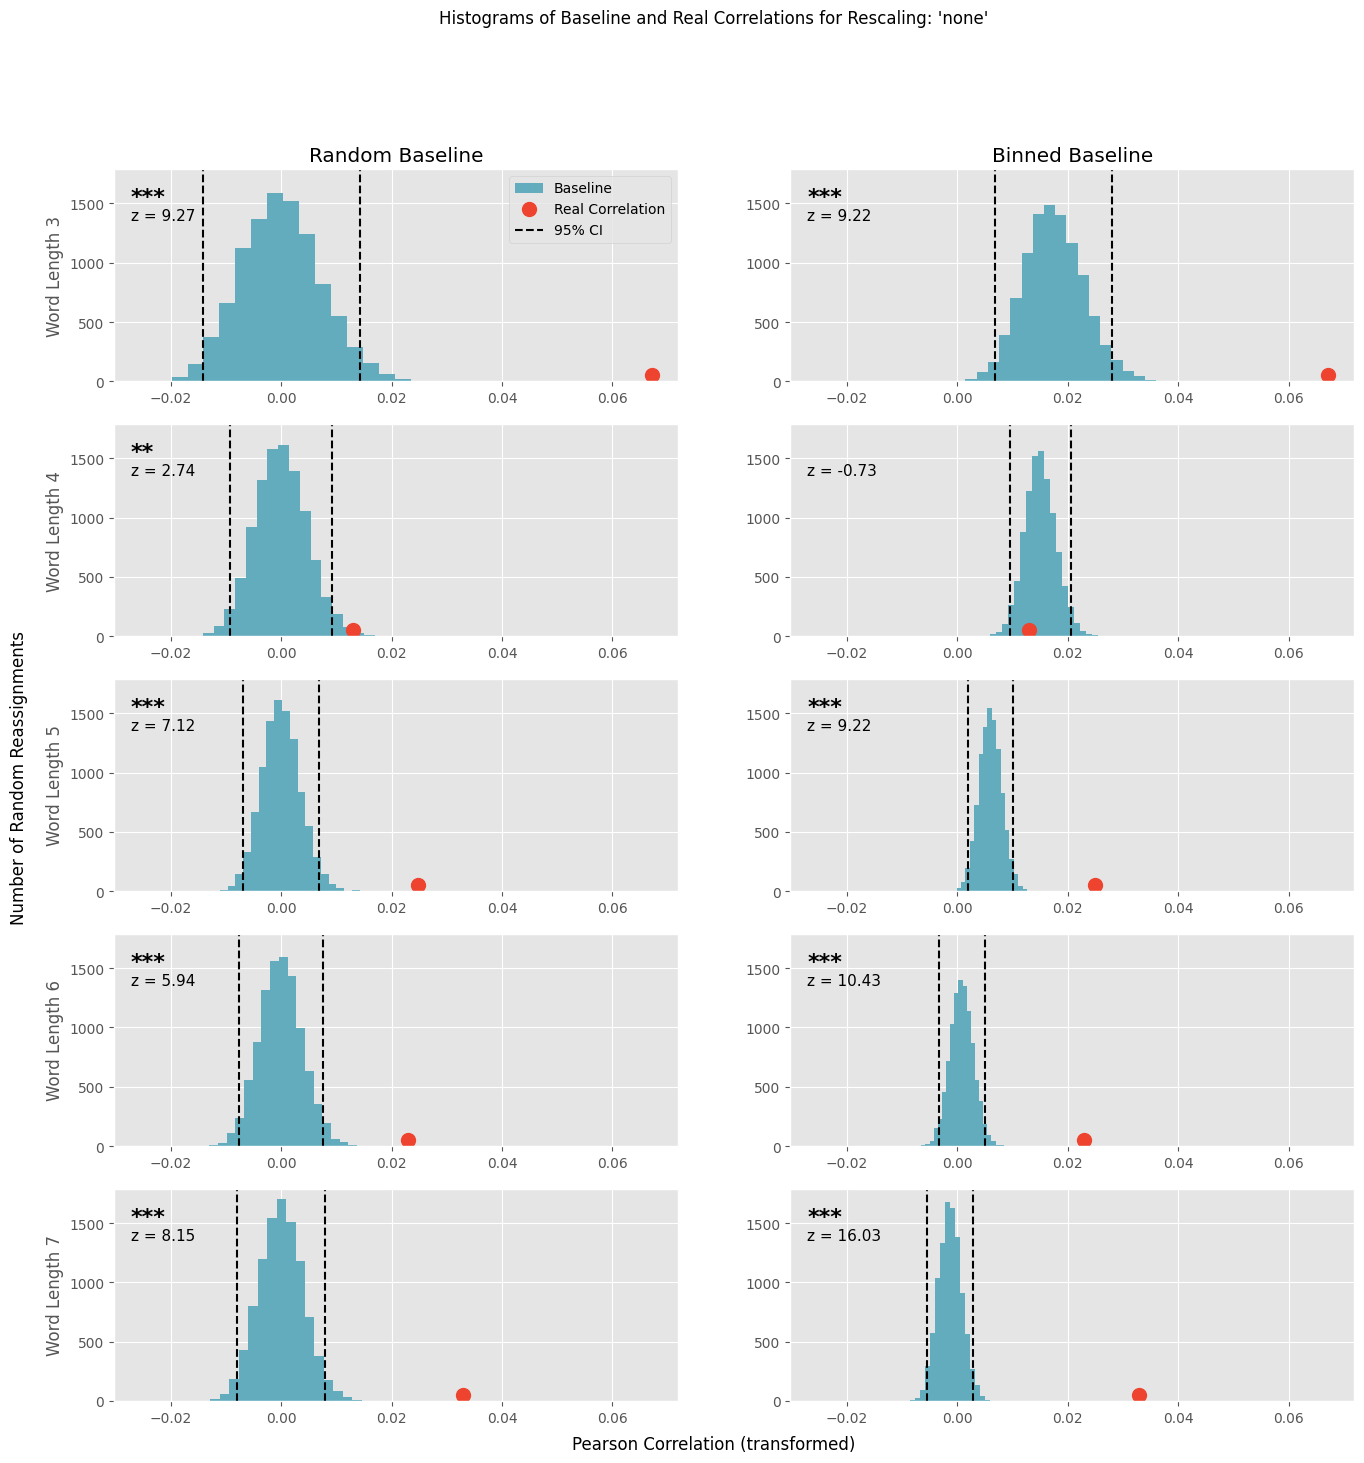

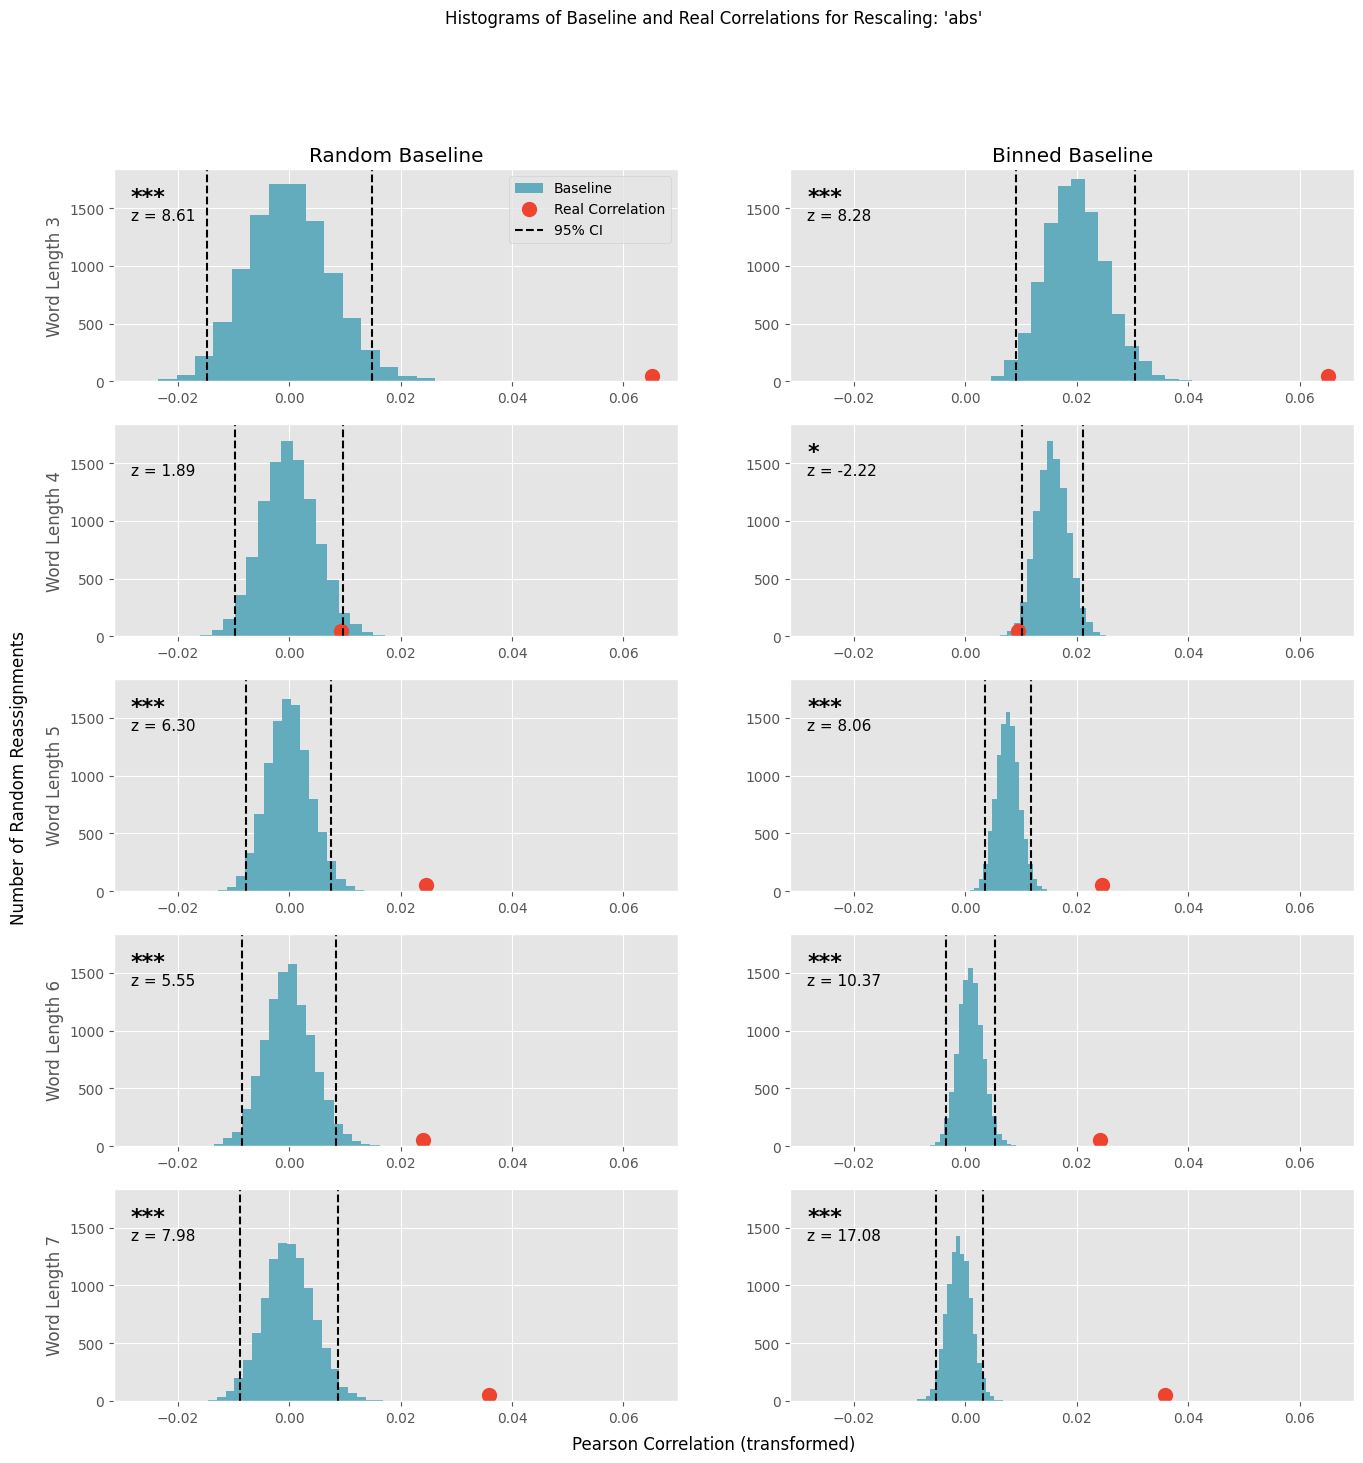

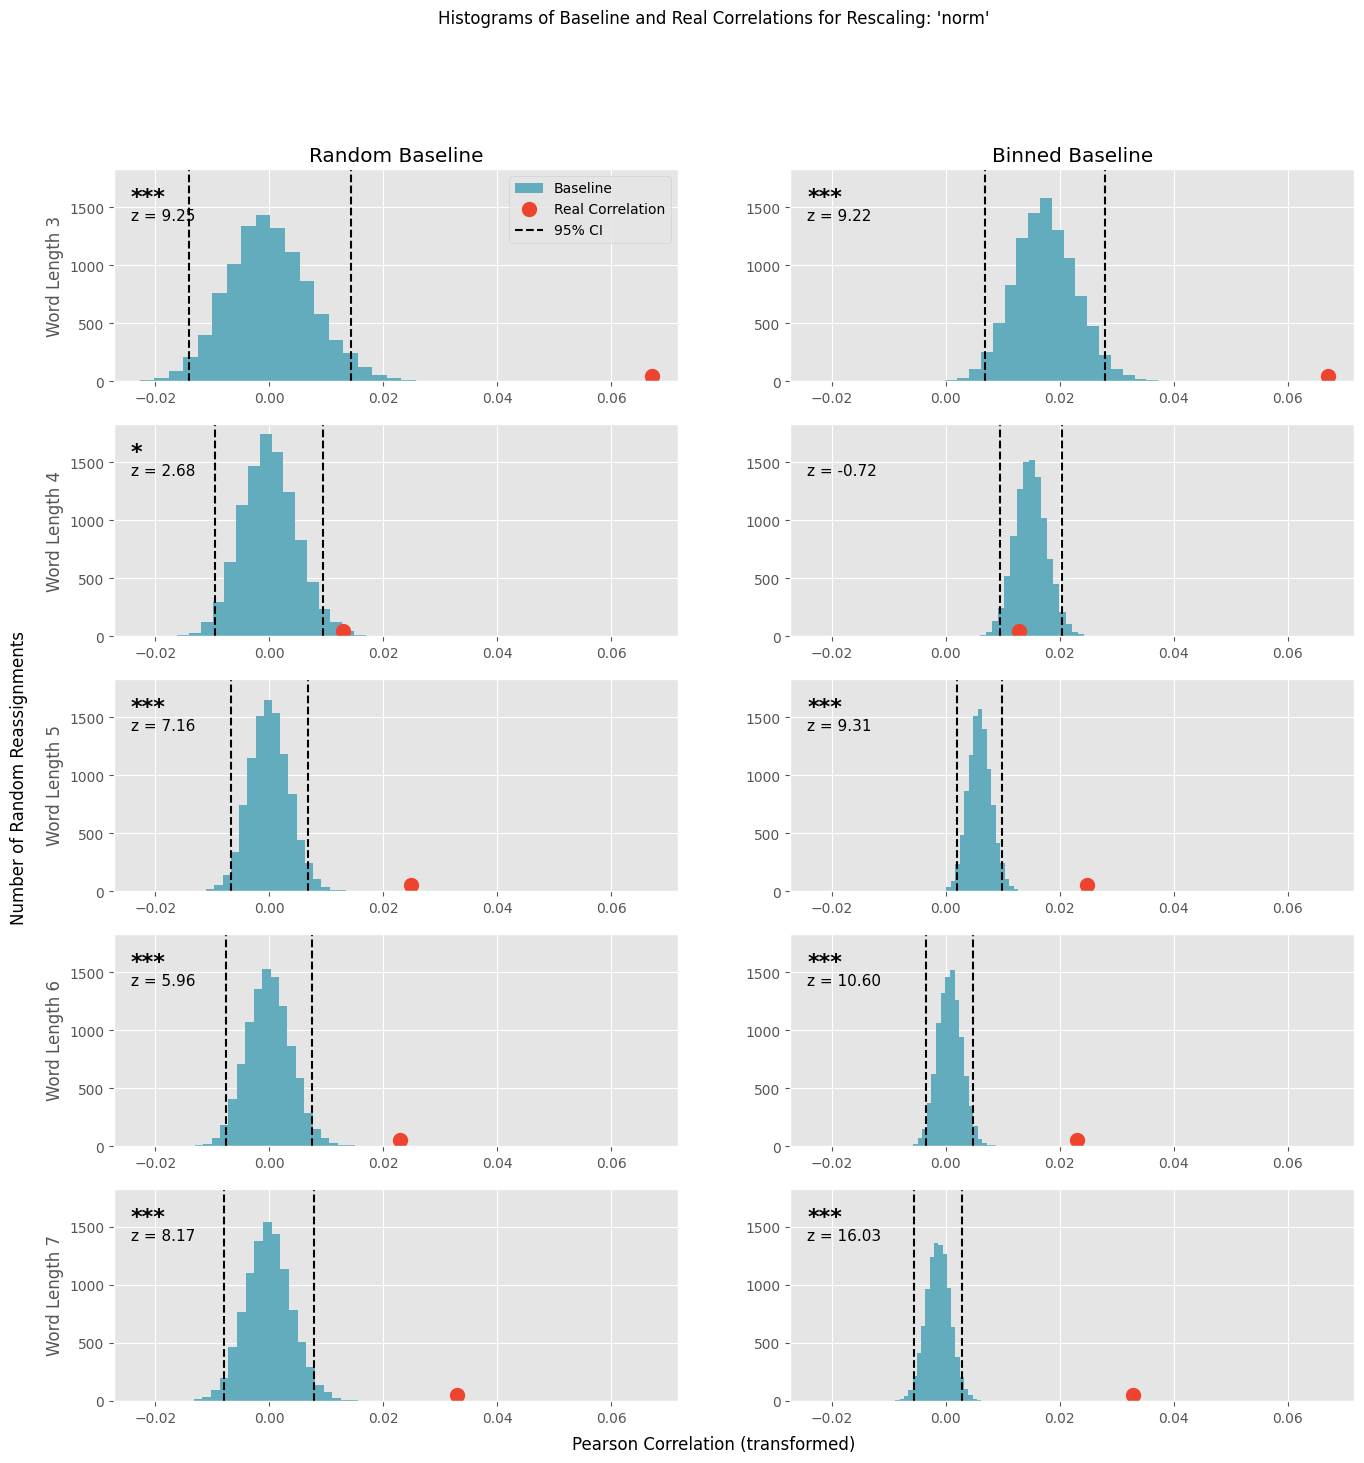

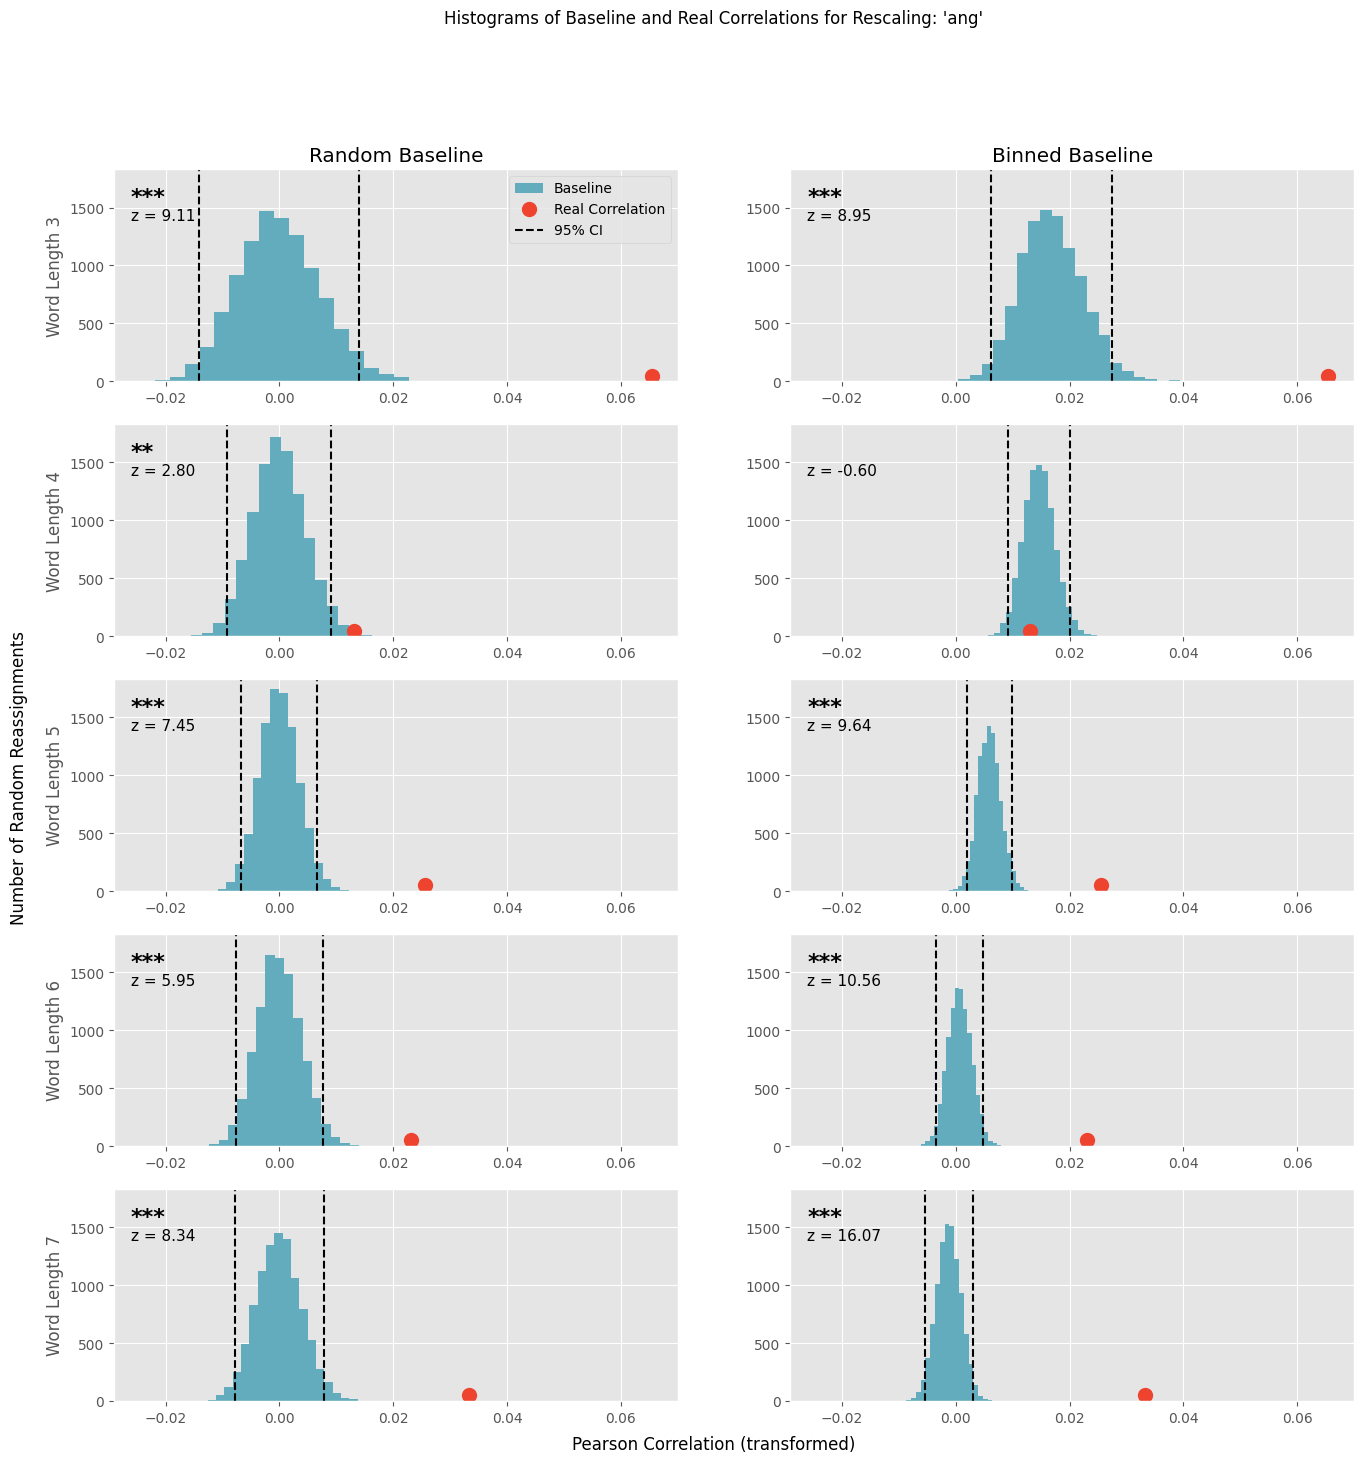

In [71]:
def plot_baseline_histograms(random_baseline_files, binned_baseline_files, real_scores_files, rescaling_types, transformed_corr, save_fig=False):
    """
    Plot histograms of baseline (random and binned) and real correlations for each rescaling type.

    Parameters:
        random_baseline_files (dict): A dictionary with rescaling types as keys and file paths to random baseline correlation files as values.
        binned_baseline_files (dict): A dictionary with rescaling types as keys and file paths to binned baseline correlation files as values.
        real_scores_files (dict): A dictionary with rescaling types as keys and file paths to real-lexicon correlation files as values.
        rescaling_types (list): A list of rescaling types to process (with values 'none', 'abs', 'norm', 'ang').
        transformed_corr (bool): If True, use transformed correlations; otherwise, use raw correlations.
        save_fig (bool): If True, save the figure; otherwise, display the plot.
    """
    # Define word lengths and baseline types (random and binned)
    word_lengths = [3, 4, 5, 6, 7]
    baseline_types = ['Random', 'Binned']
    
    # Iterate through each rescaling type
    for _, rescaling_type in enumerate(rescaling_types):
        # Create a figure for the grid of subplots
        plt.style.use('ggplot')
        
        fig, axes = plt.subplots(nrows=len(word_lengths), ncols=len(baseline_types), figsize=(16, 16), sharex=True, sharey=True)
        fig.suptitle(f"Pearson correlations between edit and cosine distance with rescaling: '{rescaling_type}'")
        
        # Load real lexicon correlation data
        real_file_path = real_scores_files[rescaling_type]
        df_real = pd.read_csv(real_file_path)
        
        # Select the appropriate correlation column based on transformed_corr
        correlation_column = 'transformed_corr' if transformed_corr else 'raw_corr'
        
        # Iterate through each word length (rows)
        for i, word_length in enumerate(word_lengths):
            # Filter real lexicon correlations by word length
            df_real_filtered = df_real[df_real['word_length'] == word_length]
            real_corr = df_real_filtered[correlation_column].iloc[0]
            
            # Iterate through each baseline type (columns)
            for j, baseline_type in enumerate(baseline_types):
                # Select the appropriate file path for the current rescaling type and baseline type
                file_path = random_baseline_files[rescaling_type] if baseline_type == 'Random' else binned_baseline_files[rescaling_type]
                
                # Load baseline data
                df_baseline = pd.read_csv(file_path)
                
                # Filter baseline data by word length
                df_baseline_filtered = df_baseline[df_baseline['word_length'] == word_length]
                
                # Select the appropriate correlation column based on transformed_corr
                baseline_correlation_column = correlation_column
                
                # Plot histogram of baseline correlations
                ax = axes[i, j]
                ax.hist(df_baseline_filtered[baseline_correlation_column], color='#63acbe', bins=20, label='Baseline')
                
                # Plot real correlation as a dot
                ax.plot(real_corr, 50, "o", color="#ee442f", label='Real Correlation', markersize=10)
                
                # Calculate mean and standard deviation of baseline correlations
                mean_corr = df_baseline_filtered[baseline_correlation_column].mean()
                std_corr = df_baseline_filtered[baseline_correlation_column].std()
                
                # Calculate the 95% confidence interval
                ci_lower = mean_corr - 1.96 * std_corr
                ci_upper = mean_corr + 1.96 * std_corr
                
                # Plot vertical dotted lines for the 95% confidence interval
                ax.axvline(ci_lower, color='black', linestyle='dashed', label='95% CI')
                ax.axvline(ci_upper, color='black', linestyle='dashed')
                
                # Calculate z-score and p-value for real correlation
                z_score = (real_corr - mean_corr) / std_corr if std_corr != 0 else np.nan
                p_value = np.exp(-0.5 * z_score**2) / np.sqrt(2 * np.pi) if z_score == z_score else np.nan
                
                # Display the z-score on the plot
                ax.text(0.03, 0.76, f'z = {z_score:.2f}', fontsize=11, transform=ax.transAxes)
                
                # Add significance markers based on the p-value
                if p_value < 0.05:
                    significance_level = '*' if p_value >= 0.01 else '**' if p_value >= 0.001 else '***'
                    ax.text(0.03, 0.84, significance_level, color='black', fontsize=16, fontweight='bold', transform=ax.transAxes)
                
                # Add row and column titles
                if i == 0:
                    ax.set_title(f'{baseline_type} Baseline')
                if j == 0:
                    ax.set_ylabel(f'Word Length {word_length}')
                # Ensure x-tick and y-tick labels are visible on each subplot
                if i == j == 0:
                    ax.legend()
                ax.tick_params(axis='x', labelbottom=True)
                ax.tick_params(axis='y', labelleft=True)
        
        # Add common title and labels
        fig.suptitle(f"Histograms of Baseline and Real Correlations for Rescaling: '{rescaling_type}'")
        specs = 'transformed' if transformed_corr else 'raw'
        fig.text(0.5, 0.08, f'Pearson Correlation ({specs})', ha='center', fontsize=12)
        fig.text(0.06, 0.5, 'Number of Random Reassignments', va='center', rotation='vertical', fontsize=12)
        
        # Save or show the figure
        if save_fig:
            filename = f"histograms_{rescaling_type}.png"
            plt.savefig(os.path.join("plots", filename))
        else:
            plt.show()

# Define file paths and rescaling types
rescaling_types = ['none', 'abs', 'norm', 'ang']

random_baseline_files = {rescaling: f'results/correlations/rd_baseline/rd_bl_corrs_{rescaling}.csv' for rescaling in rescaling_types}
binned_baseline_files = {rescaling: f'results/correlations/bin_baseline/bin_bl_corrs_{rescaling}.csv' for rescaling in rescaling_types}
real_scores_files = {rescaling: f'results/correlations/real_corr_scores/real_corrs_{rescaling}.csv' for rescaling in rescaling_types}

# Call the function
plot_baseline_histograms(random_baseline_files, binned_baseline_files, real_scores_files, rescaling_types, transformed_corr=False, save_fig=False)


# Kurtosis Analysis

Kurtosis of Random Baseline Distributions:


,abs,ang,none,norm
3,0.200342,-0.020661,0.056811,0.061401
4,0.033029,0.027697,0.095026,0.091596
5,0.089097,0.08613,0.053524,0.106141
6,0.083183,0.037704,0.058685,0.056818
7,0.005461,-0.032103,0.073698,0.076247


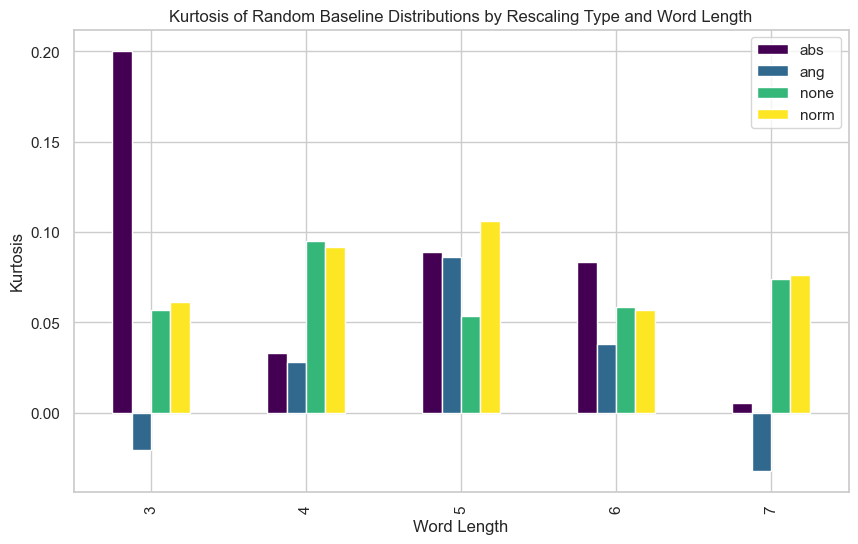

Kurtosis of Binned Baseline Distributions:


,abs,ang,none,norm
3,0.189135,0.099537,0.052677,0.006319
4,0.074647,0.029582,0.092294,0.072493
5,0.111308,-0.029379,-0.013528,0.044083
6,0.06865,-0.030008,0.018269,-0.014435
7,-0.013956,-0.008961,0.014015,0.004524


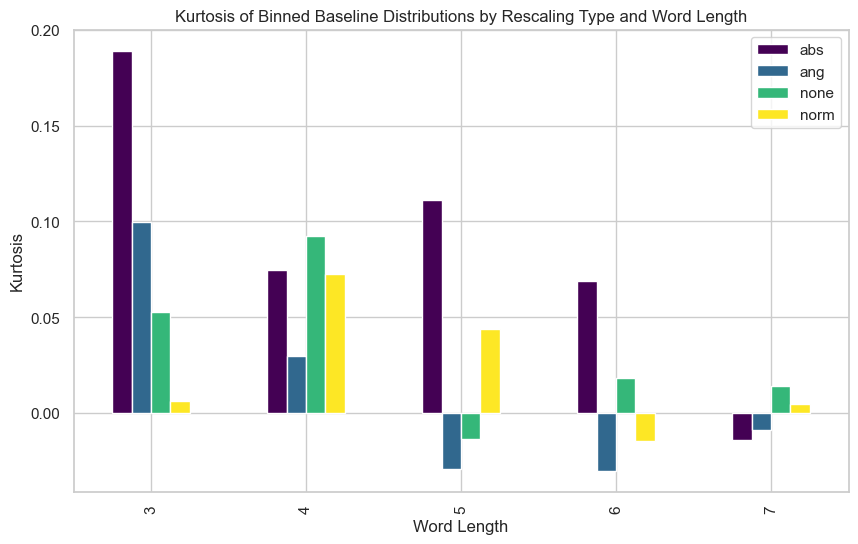

In [100]:
def analyze_kurtosis(baseline_files, baseline_type='Random', transformed_corr=True):
    word_lengths = [i for i in range(3,8)]
    
    # Create a DataFrame to store kurtosis results
    kurtosis_results = pd.DataFrame(index=word_lengths, columns=baseline_files.keys())
    
    # Loop through each rescaling type and file
    for rescaling, file_path in baseline_files.items():
        # Load baseline data
        df_baseline = pd.read_csv(file_path)
        
        # Calculate kurtosis for each word length
        for word_length in word_lengths:
            # Filter baseline data by word length
            df_filtered = df_baseline[df_baseline['word_length'] == word_length]
            
            # Select the correlation column
            correlation_column = 'transformed_corr' if transformed_corr else 'raw_corr'
            
            # Calculate kurtosis of the correlation data for the current word length
            kurtosis_value = scipy.stats.kurtosis(df_filtered[correlation_column])
            
            # Store the kurtosis value in the DataFrame
            kurtosis_results.loc[word_length, rescaling] = kurtosis_value
    
    # Display the results
    print(f'Kurtosis of {baseline_type} Baseline Distributions:')
    display(kurtosis_results)
    
    # Plot the kurtosis values as a bar plot
    kurtosis_results.plot(kind='bar', figsize=(10, 6), colormap='magma')
    plt.title(f'Kurtosis of {baseline_type} Baseline Distributions by Rescaling Type and Word Length')
    plt.ylabel('Kurtosis')
    plt.xlabel('Word Length')
    plt.show()

random_baseline_dir = os.path.join('results', 'correlations', 'rd_baseline')
random_baseline_filenames = os.listdir(random_baseline_dir)
random_baseline_files = [os.path.join(random_baseline_dir, f) for f in random_baseline_filenames]
random_baseline_files_dict = {rescaling:file for rescaling, file in zip(sorted(globals.rescaling_types_abrev), sorted(random_baseline_files))}

binned_baseline_dir = os.path.join('results', 'correlations', 'bin_baseline')
binned_baseline_filenames = os.listdir(binned_baseline_dir)
binned_baseline_files = [os.path.join(binned_baseline_dir, f) for f in binned_baseline_filenames]
binned_baseline_files_dict = {rescaling:file for rescaling, file in zip(sorted(globals.rescaling_types_abrev), sorted(binned_baseline_files))}

# Analyze kurtosis for random baseline files
analyze_kurtosis(random_baseline_files_dict, baseline_type='Random')

# Analyze kurtosis for binned baseline files
analyze_kurtosis(binned_baseline_files_dict, baseline_type='Binned')

Reference values:  
- Nnormal distribution has a kurtosis (close to) <i>equal to 3</i> and is called <b>mesokurtic</b>.
- Distributions with kurtosis <i>lower than 3</i> are <b>platykurtic</b>.
- Distributions with kurtosis <i>higher than 3</i> are <b>leptokurtic</b>.